In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from utils import constants as cnst, u_darrays as uda
import salem
import xarray as xr
import ipdb
# Some defaults
cmap = plt.get_cmap('RdBu_r')
sns.set_context('talk')
sns.set_style('ticks')

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
chirps = '/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_2015.nc'
gpm = '/media/ck/Elements/SouthAmerica/GPM/daily_precipCal_onERA/*'+'.2015'+'*.nc'
                        

fpath = cnst.network_data + 'figs/HUARAZ/'

fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
isbuffer = [-79, -74, -12, -7]

#isbuffer = [-74.5, -65, -20, -13] Altiplano

sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)
da3list = []
for mm in range(1,13):   #['01', '02', '03', '04']
    mcs = cnst.GRIDSAT_PERU + 'daily_-15ALLkm2_UTC_DAY_onBIGERA/gridsat_WA_-15Min_ALLkm2_UTCDay_onERA_2015-'+str(mm).zfill(2)+'.nc.nc'
    da3list.append(xr.open_dataset(mcs).sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3])))
da3 = xr.concat(da3list, dim='time')
ca = xr.open_dataset(chirps).sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))

gpm = xr.open_mfdataset(gpm, combine='nested', concat_dim='time').load().sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
datetimeindex = gpm.indexes['time'].to_datetimeindex()
gpm['time'] = datetimeindex

# This masks out the data which is not in the region


da3 = da3.salem.roi(shape=sdf)#.mean(['lat', 'lon'])*100
ca = ca.salem.roi(shape=sdf)#.max(['latitude', 'longitude'])
gpm = gpm.salem.roi(shape=sdf)
tag = 'RioSanta'

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


In [4]:
def readERA(var):

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [5]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65))
era = era.salem.roi(shape=sdf)

In [6]:
era_line = era['u'].mean(['longitude','latitude']).isel(time=era['time.year']==2015).rolling(time=5, min_periods=3, center=True).mean(dim='time')
gpm_line = gpm.mean(['longitude','latitude']).rolling(time=5, min_periods=3, center=True).mean(dim='time')
ca_line = ca.mean(['longitude','latitude']).rolling(time=5, min_periods=3, center=True).mean(dim='time')
gridsat_line = da3.mean(['longitude','latitude']).rolling(time=5, min_periods=3, center=True).mean(dim='time')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Reductions will be applied along the rolling dimension '['time']'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  """Entry point for launching an IPython kernel.


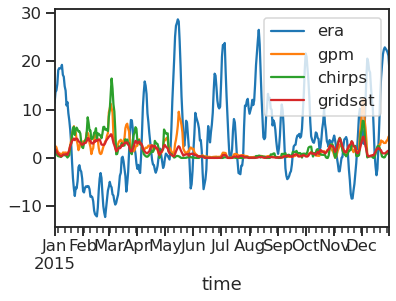

In [7]:
df = pd.DataFrame()
df['era'] = era_line.to_series()
df['gpm'] = gpm_line['precip'].to_series()
df['chirps'] = ca_line['precip'].to_series()
df['gridsat'] = (gridsat_line['tir']/-1000).to_series()
df.plot();

In [8]:
dfs = df.loc['2015/01/01':'2015/01/30'].copy()

<Figure size 1080x720 with 0 Axes>

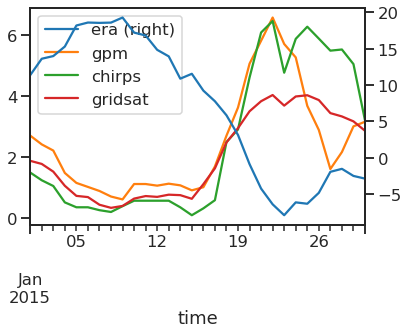

In [9]:
# Rolling average
f=plt.figure(figsize=(15,10))
dfs.plot(secondary_y='era');  #.rolling(5, center=True).mean()

In [10]:
gpm['time']

<xarray.DataArray 'time' (time: 365)>
array(['2015-01-01T00:00:00.000000000', '2015-01-02T00:00:00.000000000',
       '2015-01-03T00:00:00.000000000', ..., '2015-12-29T00:00:00.000000000',
       '2015-12-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31

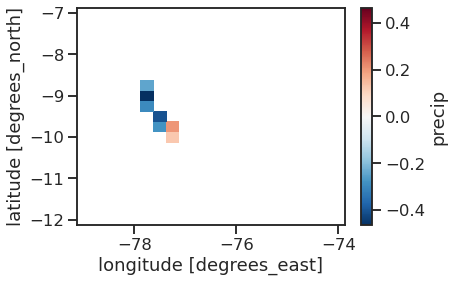

In [11]:
(ca['precip']-gpm['precip']).mean('time').plot.pcolormesh()

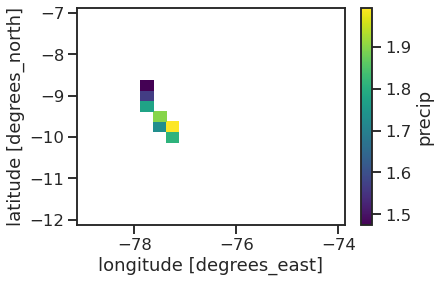

In [12]:
ca['precip'].mean('time').plot.pcolormesh()

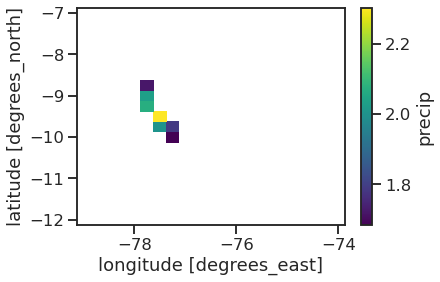

In [13]:
(gpm['precip']).mean('time').plot.pcolormesh()

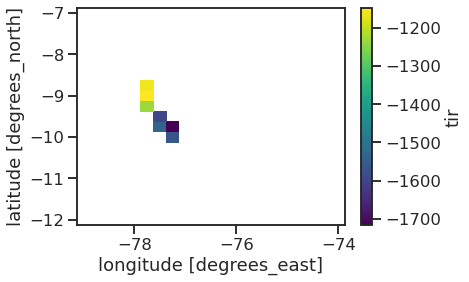

In [14]:
(da3['tir']).mean('time').plot.pcolormesh()

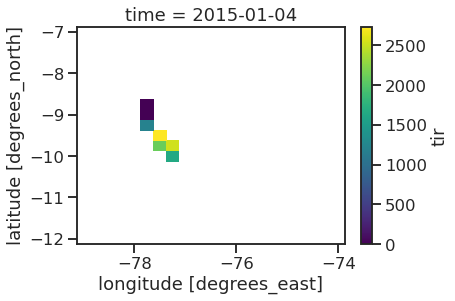

In [15]:
(da3['tir'].isel(time=3)*(-1)).plot()

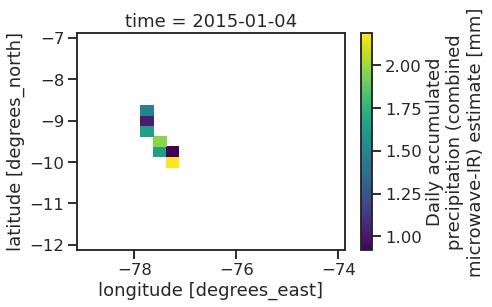

In [16]:
(gpm['precip'].isel(time=3)).plot()

In [17]:
cam = ca.isel(time=(ca['time.month']>=1) & (ca['time.month']<=12))

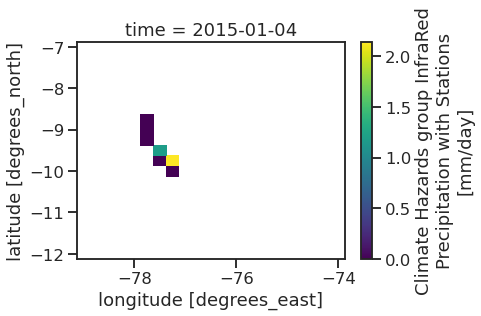

In [18]:
cam['precip'].isel(time=3).plot.pcolormesh(vmin=0)

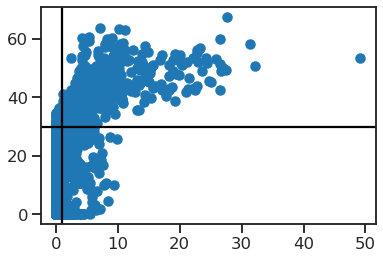

In [19]:
plt.scatter(cam['precip'],da3['tir']*-1/100)
plt.axvline(1, color='k')
plt.axhline(30, color='k')

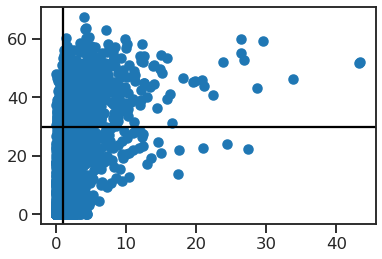

In [20]:
plt.scatter(gpm['precip'],da3['tir']*-1/100)
plt.axvline(1, color='k')
plt.axhline(30, color='k')

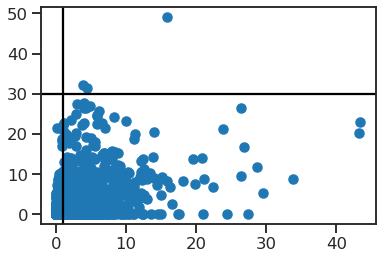

In [21]:
plt.scatter(gpm['precip'],cam['precip'])
plt.axvline(1, color='k')
plt.axhline(30, color='k')

In [28]:
def var2_binning_mean(xvar, yvar, xbins):
    """
    :param xvar: xvar of the 2dhist
    :param yvar: yvar of the 2d hist
    :param xbins: bins to use for the xvar
    :param ybins: bins to use for the yvar
    :param varlist: dictionary of variables to put into histogram
    :param varpick: list of variables in dic to calculate
    :return:
    """
    outdic = {}
    outdic['y'] = []


    for issh, shl in enumerate(xbins[0:-1]):

        mask = (xvar > shl) & (xvar <= xbins[issh + 1])

        outdic['y'].append(np.sum((yvar[mask])<-40)/np.sum(mask))

    outdic['xbins'] = (np.round(xbins[0:-1]+((xbins[1::]-xbins[0:-1])/2),2))


    return outdic

In [32]:
(cam['precip']).max()

<xarray.DataArray 'precip' ()>
array(49.17214966)

In [39]:
dic = var2_binning_mean((cam['precip']).values.flatten(), (da3['tir']/100).values.flatten(), xbins=np.arange(0,21,1)) #xbins=np.arange(-90,-14,5))

#dicgp = var2_binning_mean((da3['tir']/100).values.flatten(), (gpm['precip']).values.flatten(), xbins=np.arange(-90,-14,5))

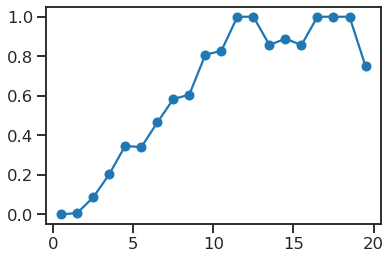

In [40]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(dic['xbins'], dic['y'], '-o')

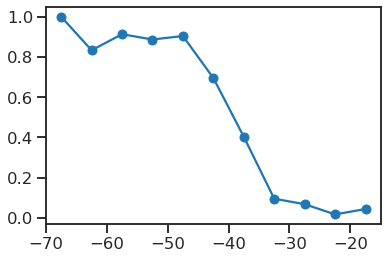

In [24]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(dic['xbins'], dic['y'], '-o')

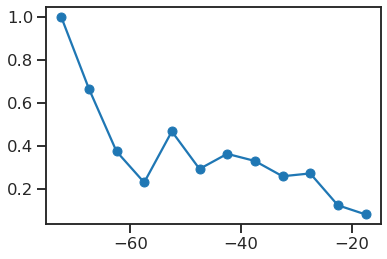

In [161]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(dicgp['xbins'], dicgp['y'], '-o')

In [124]:
da3 = da3.mean(['lat', 'lon'])*100
ca = ca.mean(['latitude', 'longitude'])

In [125]:
year_season = xr.DataArray(da3.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
                               coords=[da3.time], name='year_season')

In [298]:
np.mean(ca[(ca['time.month']>=12) | (ca['time.month']<=2)])


<xarray.DataArray 'precip' ()>
array(102.716415, dtype=float32)

In [299]:
np.mean(ca[(ca['time.month']>=3) & (ca['time.month']<=6)].isel(time=))

<xarray.DataArray 'precip' ()>
array(63.585667, dtype=float32)

In [300]:
np.mean(ca[(ca['time.month']>=8) & (ca['time.month']<=11)])

<xarray.DataArray 'precip' ()>
array(39.28994, dtype=float32)

In [127]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

In [391]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}
def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

In [445]:
# Wrap it into a simple function
def season_mean(ds, calendar='standard'):
    # Make a DataArray of season/year groups
#     year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
#                                coords=[ds.time], name='year_season')

    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),coords=[ds.time],name='month_length')
    result = ((ds * month_length).resample(time='QS-DEC').sum() /  month_length.where(ds.notnull()).resample(time='QS-DEC').sum())

    # Calculate the weighted average
    return result[(result['time.month']==12)]# | (result['time.month']==9)   | (result['time.month']==3)]


In [446]:
gts = season_mean(da3)

In [447]:
cts = season_mean(ca)

In [354]:
cts = cts.groupby('time.year').mean('time')

In [395]:
cts

<xarray.DataArray (time: 38)>
array([57.30710334, 59.18247931, 40.65364117, 49.15804802, 34.33204751,
       31.14182038, 41.52583774, 46.59495465, 63.42366011, 66.47399232,
       48.2840109 , 33.05338496, 70.82829151, 39.51350122, 50.02802444,
       42.79577152, 58.77380908, 53.43159548, 53.6891832 , 36.44690863,
       71.09146286, 79.74827387, 33.82098984, 62.00397642, 32.59878087,
       51.33030638, 51.43920027, 53.14518525, 59.91792201, 52.98166447,
       49.84420181, 50.88765337, 48.68245756, 43.23674175, 38.41293327,
       34.38803941, 47.1666471 , 56.8067339 ])
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1982-09-01 ... 2018-09-01

In [246]:
def readERA():

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/u200_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [247]:
era = readERA()
era = era.sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
topo_on_era = era.salem.lookup_transform(topo)
era = era.where(topo_on_era>1000)

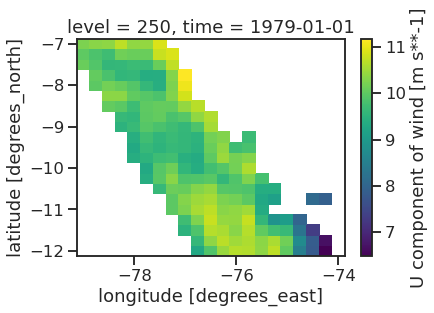

In [248]:
era['u'][0,:,:].plot()

In [19]:
era_valley = era['u'].mean(['latitude', 'longitude']) #salem.roi(shape=sdf)
ets = season_mean(era_valley)

In [396]:
ets

time
1984-12-01    -4.588127
1985-12-01    -5.240607
1986-12-01    -1.721192
1987-12-01     0.965106
1988-12-01    -5.373281
1989-12-01     4.087871
1990-12-01    -5.330614
1991-12-01     7.805148
1992-12-01     2.013634
1993-12-01    -6.227279
1994-12-01    -2.704102
1995-12-01    -4.912859
1996-12-01    -5.497720
1997-12-01    -5.867680
1998-12-01    -7.872404
1999-12-01    -7.768601
2000-12-01    -4.717371
2001-12-01    -0.429910
2002-12-01    -3.549928
2003-12-01    -5.080310
2004-12-01    -1.539026
2005-12-01    -6.349952
2006-12-01    -5.531655
2007-12-01    -7.385946
2008-12-01    -5.921727
2009-12-01    -3.280254
2010-12-01   -10.575460
2011-12-01    -2.794293
2012-12-01    -0.704850
2013-12-01    -5.776604
2014-12-01    -1.939403
2015-12-01     5.344175
2016-12-01    -6.543421
2017-12-01    -4.839493
dtype: float64

In [325]:
posgrid = np.intersect1d(ets.time, gts.time)

gsat = gts.sel(time=posgrid)
ets = ets.sel(time=posgrid)

posgrid = np.intersect1d(ets.time, cts.time)
cts = cts.sel(time=posgrid)

AttributeError: 'Series' object has no attribute 'time'

In [448]:
#ets = ets.to_pandas()
#gts = gts.to_pandas()
cts = cts.to_pandas()

In [449]:
cts.index[0]

Timestamp('1980-12-01 00:00:00')

In [450]:
cts.index[-1]

Timestamp('2018-12-01 00:00:00')

In [451]:
enso = '/home/ck/DIR/mymachine/ENSO/ONI.csv'#'/home/ck/DIR/mymachine/ENSO/meiv2.data'
ysst_start = 1980#cts.index[0]#.year
ysst_end = 2018 #cts.index[-1]#.year

In [452]:
ens = pd.read_csv(enso, sep=',', engine='python', names=np.arange(0, 13),index_col=0)
ensmonth = ens[12]

eens = ensmonth.loc[ysst_start:ysst_end]
#cts = cts.loc[ysst_start:ysst_end]

In [453]:
ysst_start

1980

In [454]:
ysst_end

2018

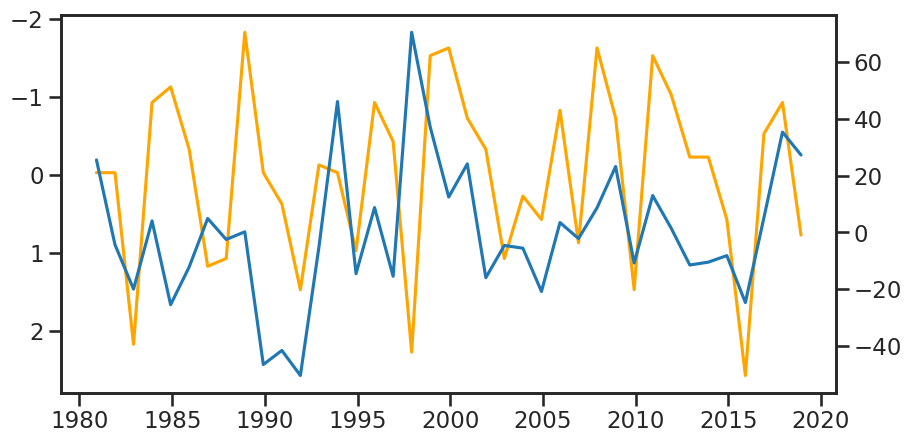

In [455]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
ax.plot(cts.index, eens-np.mean(eens), color='orange')
ax.set_ylim(ax.get_ylim()[::-1])
ax1 = ax.twinx()
ax1.plot(cts.index, cts-np.mean(cts))

In [456]:
cts.loc[(eens>=0.5).values]

time
1982-12-01     82.204515
1986-12-01    107.070901
1987-12-01     99.668729
1991-12-01     51.799908
1994-12-01     87.629047
1997-12-01    172.590044
2002-12-01     97.565356
2004-12-01     81.365437
2006-12-01     99.988027
2009-12-01     91.381886
2014-12-01     93.986701
2015-12-01     77.476074
2018-12-01    129.413615
dtype: float64

In [457]:
cts.loc[(eens<=-0.5).values]

time
1983-12-01    106.207629
1984-12-01     76.703137
1988-12-01    102.359394
1995-12-01    110.891059
1998-12-01    139.293100
1999-12-01    114.603483
2000-12-01    126.268222
2005-12-01    105.632023
2007-12-01    110.819953
2008-12-01    125.349439
2010-12-01    115.122379
2011-12-01    103.638413
2016-12-01    107.419095
2017-12-01    137.469455
dtype: float64

In [458]:
nino = cts.loc[(eens>=0.5).values]

In [459]:
nina = cts.loc[(eens<=-0.5).values]

In [460]:
nino_mean = np.mean(nino)

In [461]:
nina_mean = np.mean(nina)

In [462]:
print(nino_mean, nina_mean, np.mean(cts))

97.85694149173236 112.98405571374009 102.12509741535655


In [463]:
(nina_mean-nino_mean)/np.mean(cts)

0.14812337618130947

In [464]:
(nina_mean-nino_mean)

15.127114222007734

In [465]:
stats.ttest_ind(nino,nina)

Ttest_indResult(statistic=-1.7109131684653014, pvalue=0.09947967665635365)

In [41]:
(eens>=0.5).values

array([False, False,  True,  True, False, False, False,  True, False,
       False,  True, False, False,  True, False, False, False, False,
        True, False,  True, False,  True, False, False,  True, False,
       False, False, False,  True,  True, False, False])

In [22]:
ets

time
1984-12-01    -4.588127
1985-12-01    -5.240607
1986-12-01    -1.721192
1987-12-01     0.965106
1988-12-01    -5.373281
1989-12-01     4.087871
1990-12-01    -5.330614
1991-12-01     7.805148
1992-12-01     2.013634
1993-12-01    -6.227279
1994-12-01    -2.704102
1995-12-01    -4.912859
1996-12-01    -5.497720
1997-12-01    -5.867680
1998-12-01    -7.872404
1999-12-01    -7.768601
2000-12-01    -4.717371
2001-12-01    -0.429910
2002-12-01    -3.549928
2003-12-01    -5.080310
2004-12-01    -1.539026
2005-12-01    -6.349952
2006-12-01    -5.531655
2007-12-01    -7.385946
2008-12-01    -5.921727
2009-12-01    -3.280254
2010-12-01   -10.575460
2011-12-01    -2.794293
2012-12-01    -0.704850
2013-12-01    -5.776604
2014-12-01    -1.939403
2015-12-01     5.344175
2016-12-01    -6.543421
2017-12-01    -4.839493
dtype: float64

DatetimeIndex(['1994-12-01', '1995-12-01', '1996-12-01', '1997-12-01',
               '1998-12-01', '1999-12-01', '2000-12-01', '2001-12-01',
               '2002-12-01', '2003-12-01', '2004-12-01', '2005-12-01',
               '2006-12-01', '2007-12-01', '2008-12-01', '2009-12-01',
               '2010-12-01', '2011-12-01', '2012-12-01'],
              dtype='datetime64[ns]', name='time', freq=None) LinregressResult(slope=-0.9296589511144657, intercept=15.953271047623184, rvalue=-0.6062004814125307, pvalue=0.005935262615679648, stderr=0.29581513061065356)


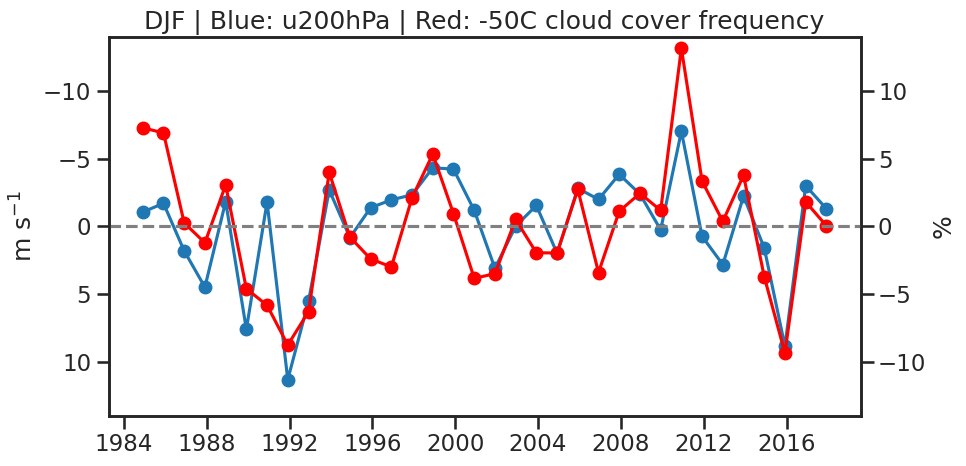

In [23]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
ax.plot((ets-np.mean(ets)), marker='o', label='u200hPa')
ax1 = ax.twinx()
ax1.plot((gts-np.mean(gts)), color='r', marker='o', label='-50C cloud cover frequency')
print(ets.index[10:-5],stats.linregress(ets.values[10:-5], gts.values[10:-5]))
plt.title('DJF | Blue: u200hPa | Red: -50C cloud cover frequency')
ax1.set_ylabel('%')
ax.set_ylabel('m s$^{-1}$')
ax1.set_ylabel('%')
ax.set_ylabel('m s$^{-1}$')
ax.set_ylim(-14,14)
ax.set_ylim(ax.get_ylim()[::-1])
ax1.set_ylim(-14,14)
plt.axhline(0, linestyle='dashed', color='grey')
plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/interannual_timeseries_corr_GRIDSATvsU200_'+tag+'.jpg')

DatetimeIndex(['1994-12-01', '1995-12-01', '1996-12-01', '1997-12-01',
               '1998-12-01', '1999-12-01', '2000-12-01', '2001-12-01',
               '2002-12-01', '2003-12-01', '2004-12-01', '2005-12-01',
               '2006-12-01', '2007-12-01', '2008-12-01', '2009-12-01',
               '2010-12-01', '2011-12-01', '2012-12-01'],
              dtype='datetime64[ns]', name='time', freq=None) LinregressResult(slope=-0.9296589511144657, intercept=15.953271047623184, rvalue=-0.6062004814125307, pvalue=0.005935262615679648, stderr=0.29581513061065356)


Text(53.58333333333333, 0.5, 'm s$^{-1}$')

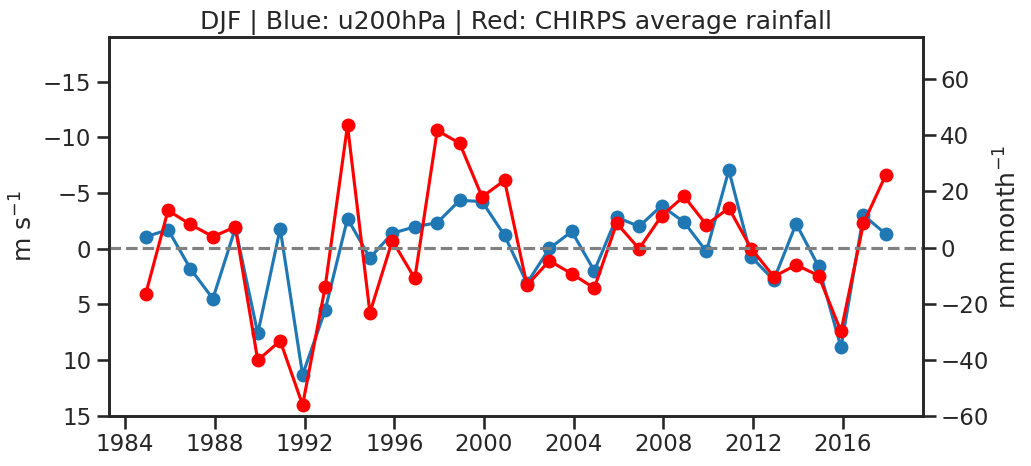

In [24]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
ax.plot((ets-np.mean(ets)), marker='o', label='u200hPa')
#ax.plot((ets-np.mean(ets)).rolling(center=True,window=10).mean()*-1, color='purple')
ax1 = ax.twinx()
ax1.plot((cts-np.mean(cts)), color='r', marker='o', label='CHIRPS average rainfall')
print(ets.index[10:-5],stats.linregress(ets.values[10:-5], gts.values[10:-5]))
plt.title('DJF | Blue: u200hPa | Red: CHIRPS average rainfall')

plt.axhline(0, linestyle='dashed', color='grey')
ax.set_ylim(-19,15)
ax.set_ylim(ax.get_ylim()[::-1])
ax1.set_ylim(-60,75)
plt.tight_layout()
ax1.set_ylabel('mm month$^{-1}$')
ax.set_ylabel('m s$^{-1}$')
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/interannual_timeseries_corr_CHIRPSvsU200_'+tag+'.jpg')

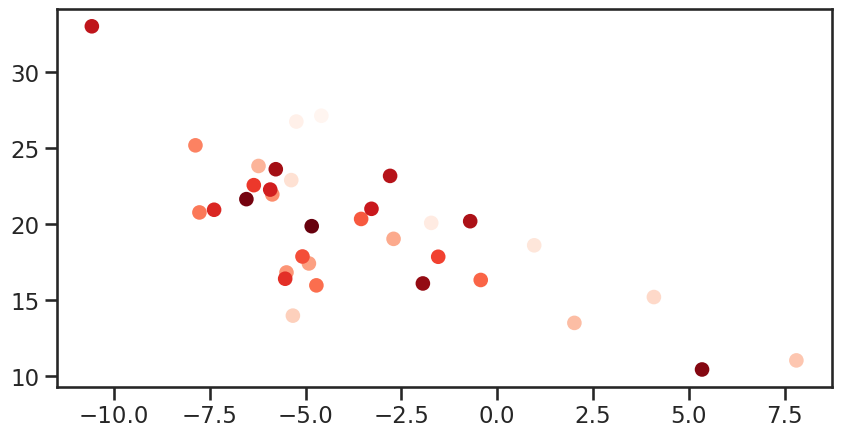

In [25]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
plt.scatter(ets,gts, c=ets.index, cmap='Reds')

### Trend analysis 

In [26]:
# the trend are computed on time series at least 20yrs long
start_years = ets.index[:-5]
start_years_p = start_years.year
end_years = ets.index[5:]
end_years_p = end_years.year
ny = len(start_years)
extent = (start_years_p[0], start_years_p[-1], end_years_p[0], end_years_p[-1])  # needed for the plot later

In [27]:
extent

(1984, 2012, 1989, 2017)

In [28]:
# fill the triangle
trend = np.zeros((ny, ny)) *np.nan
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data1 = ets.loc[start_year:end_year]
        data2 = cts.loc[start_year:end_year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

In [29]:
trend = np.array(trend)
sig = np.array(sig)

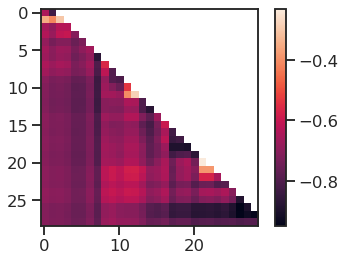

In [30]:
plt.imshow(trend)
plt.colorbar()

### Plot 

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: No contour levels were found within the data range.
  


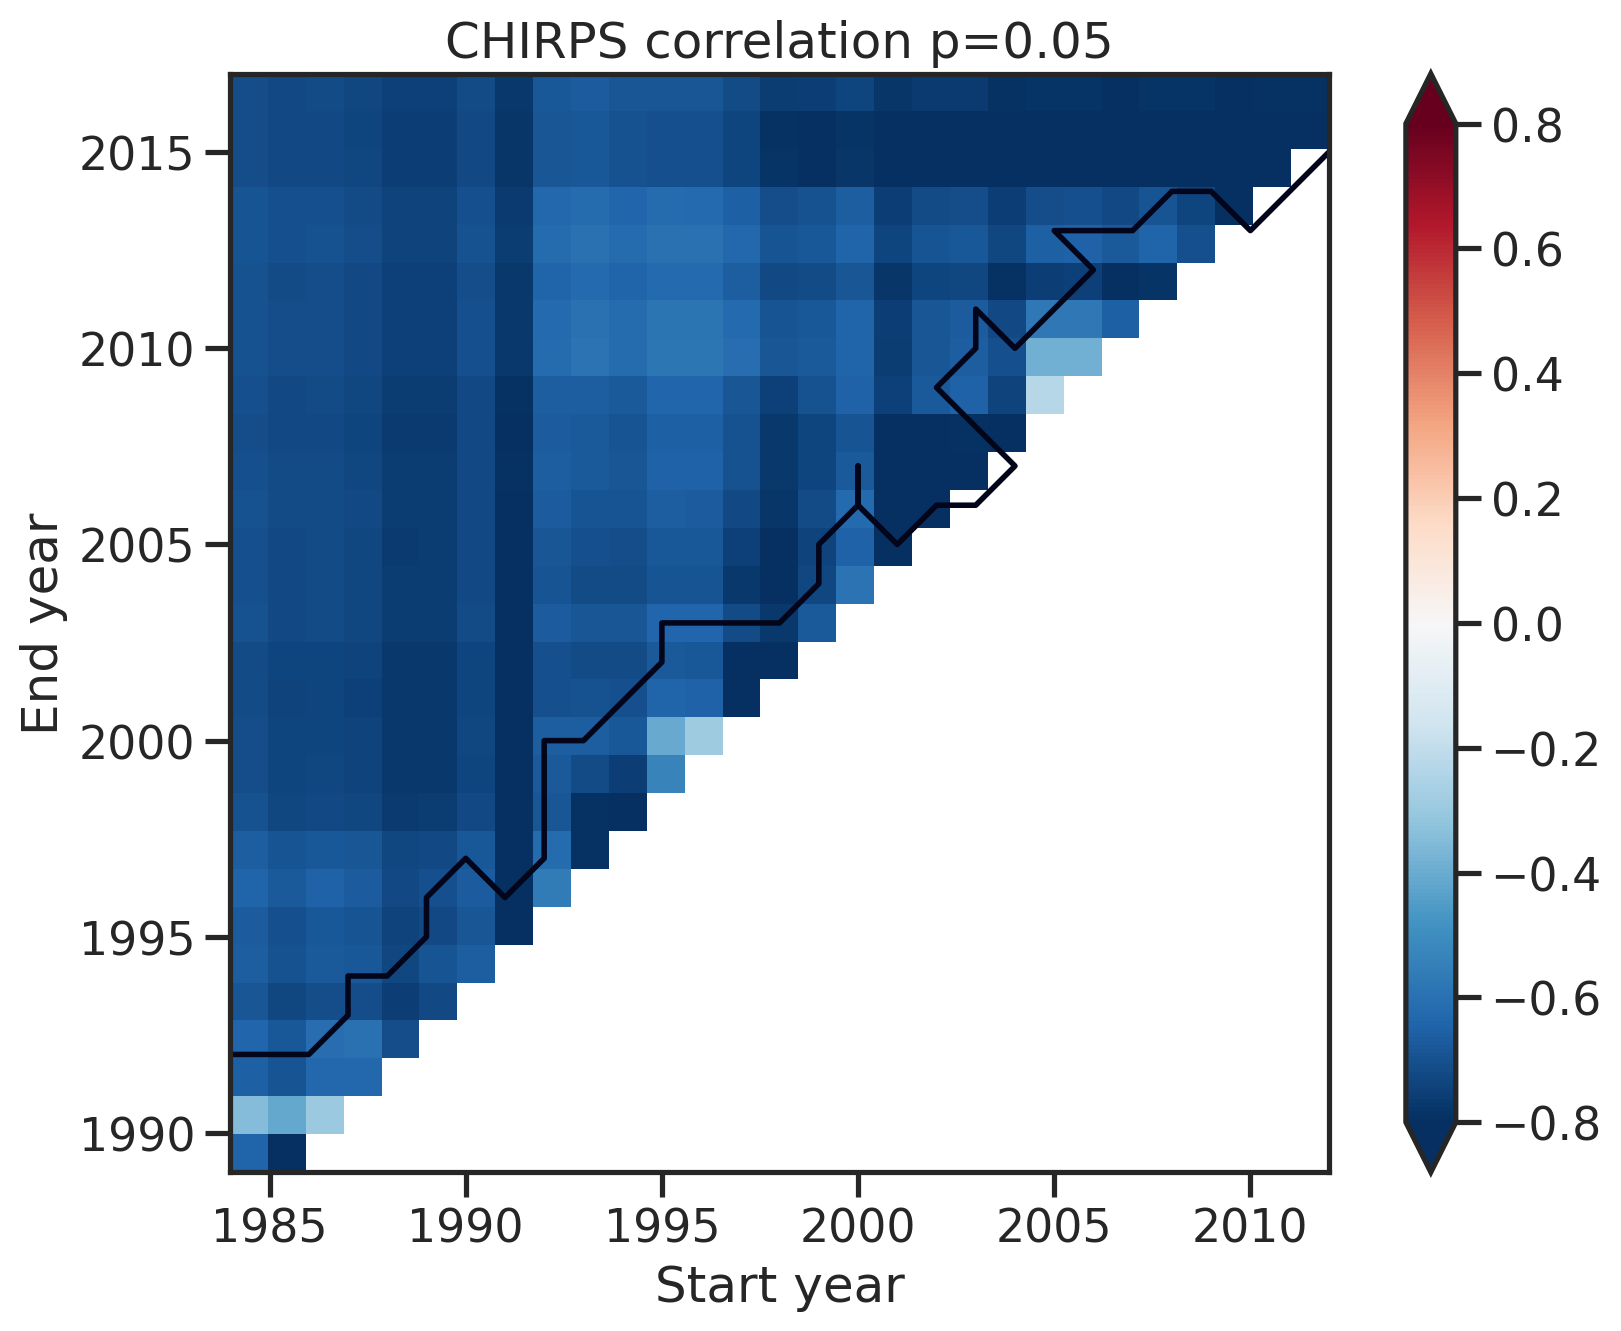

In [31]:
# plot
f= plt.figure(figsize=(9, 7),dpi=200)
ax = f.add_subplot(111)
im = plt.imshow(trend, cmap=cmap, vmin=-0.8, vmax=0.8, extent=extent, interpolation='none', origin='lower')  #, 
#im = plt.contourf(start_years, end_years, trend, linewidths=1, levels=np.arange(-0.8,0.81,0.1), cmap='RdBu_r')
plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=2, levels=[-1,0,1])
plt.colorbar(im, extend='both');
# ax.set_xtick_labels(start_years_p)
# ax.set_ytick_labels(end_years_p)
plt.title('CHIRPS correlation p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_DJF_CHIRPSvsU200_'+tag+'.jpg')

In [32]:
# fill the triangle
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data1 = ets.loc[start_year:end_year]
        data2 = gts.loc[start_year:end_year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


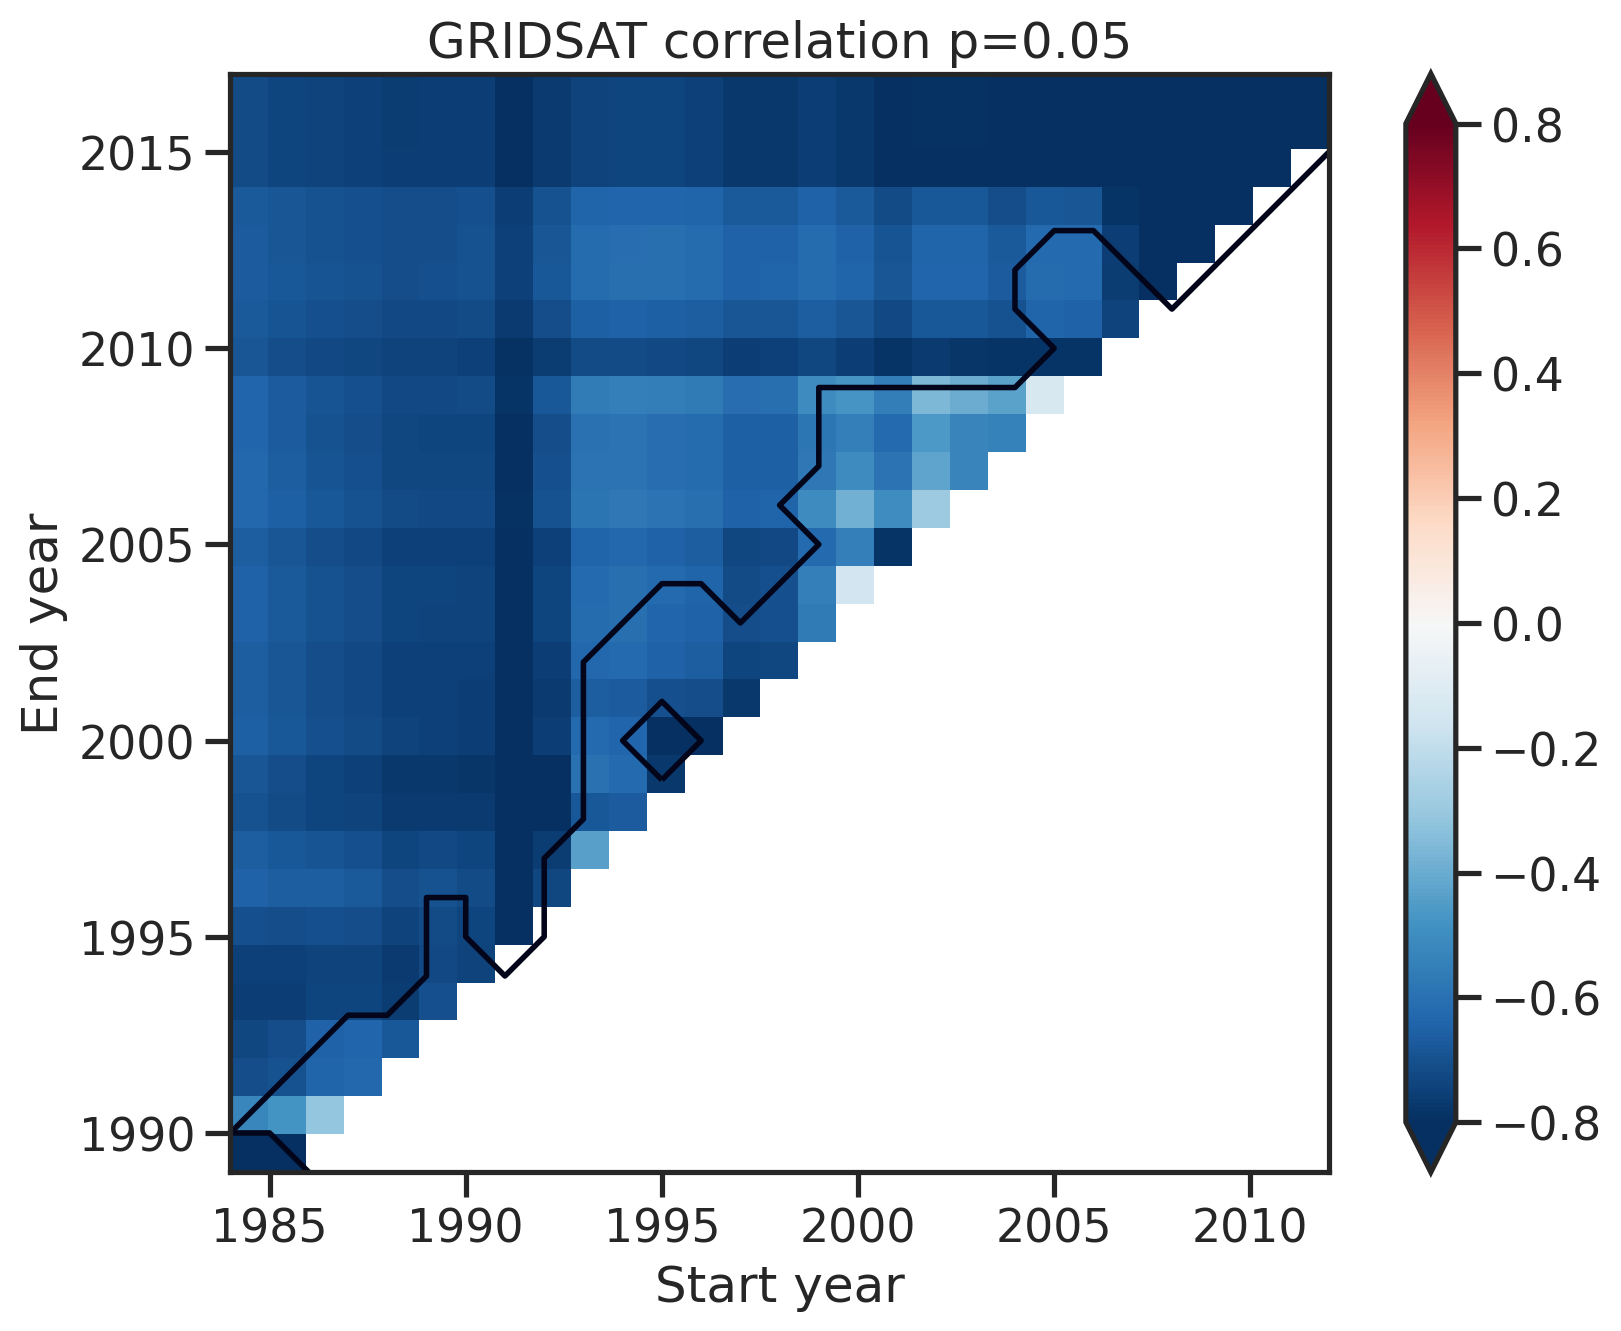

In [33]:
f= plt.figure(figsize=(9, 7), dpi=200)
ax = f.add_subplot(111)
im = plt.imshow(trend, cmap=cmap, vmin=-0.8, vmax=0.8, extent=extent, interpolation='none', origin='lower')  #, 
#im = plt.contourf(start_years, end_years, trend, linewidths=1, levels=np.arange(-0.8,0.81,0.1), cmap='RdBu_r')
plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=2, levels=[-1,0,1])
plt.colorbar(im, extend='both');
plt.title('GRIDSAT correlation p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
#plt.savefig('triangle_giss.png', dpi=150)
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_DJF_GRIDSATvsU200_'+tag+'.jpg')

In [34]:
def monthly(m, d1,d2):

    dg = d1.sel(time=(d1['time.month']==m)).groupby('time.year').mean('time')
    de = d2.sel(time=(d2['time.month']==m)).groupby('time.year').mean('time')
                 
    posgrid = np.intersect1d(dg.year.values, de.year.values)

    de = de.sel(year=posgrid)
    dg = dg.sel(year=posgrid)
                 
    dg = dg.to_pandas()
    de = de.to_pandas()
                 
    # fill the triangle
    trend = np.zeros((ny, ny)) * np.NaN
    sig = np.ones((ny, ny)) 
    for i, start_year in enumerate(start_years_p):
        for j, end_year in enumerate(end_years_p):
            data1 = dg.loc[start_year:end_year]
            data2 = de.loc[start_year:end_year]
            if len(data1) < 5:
                continue
            slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
            trend[j, i] = r   # for decadal trends
            sig[j, i] = p_val
    
    return trend, sig

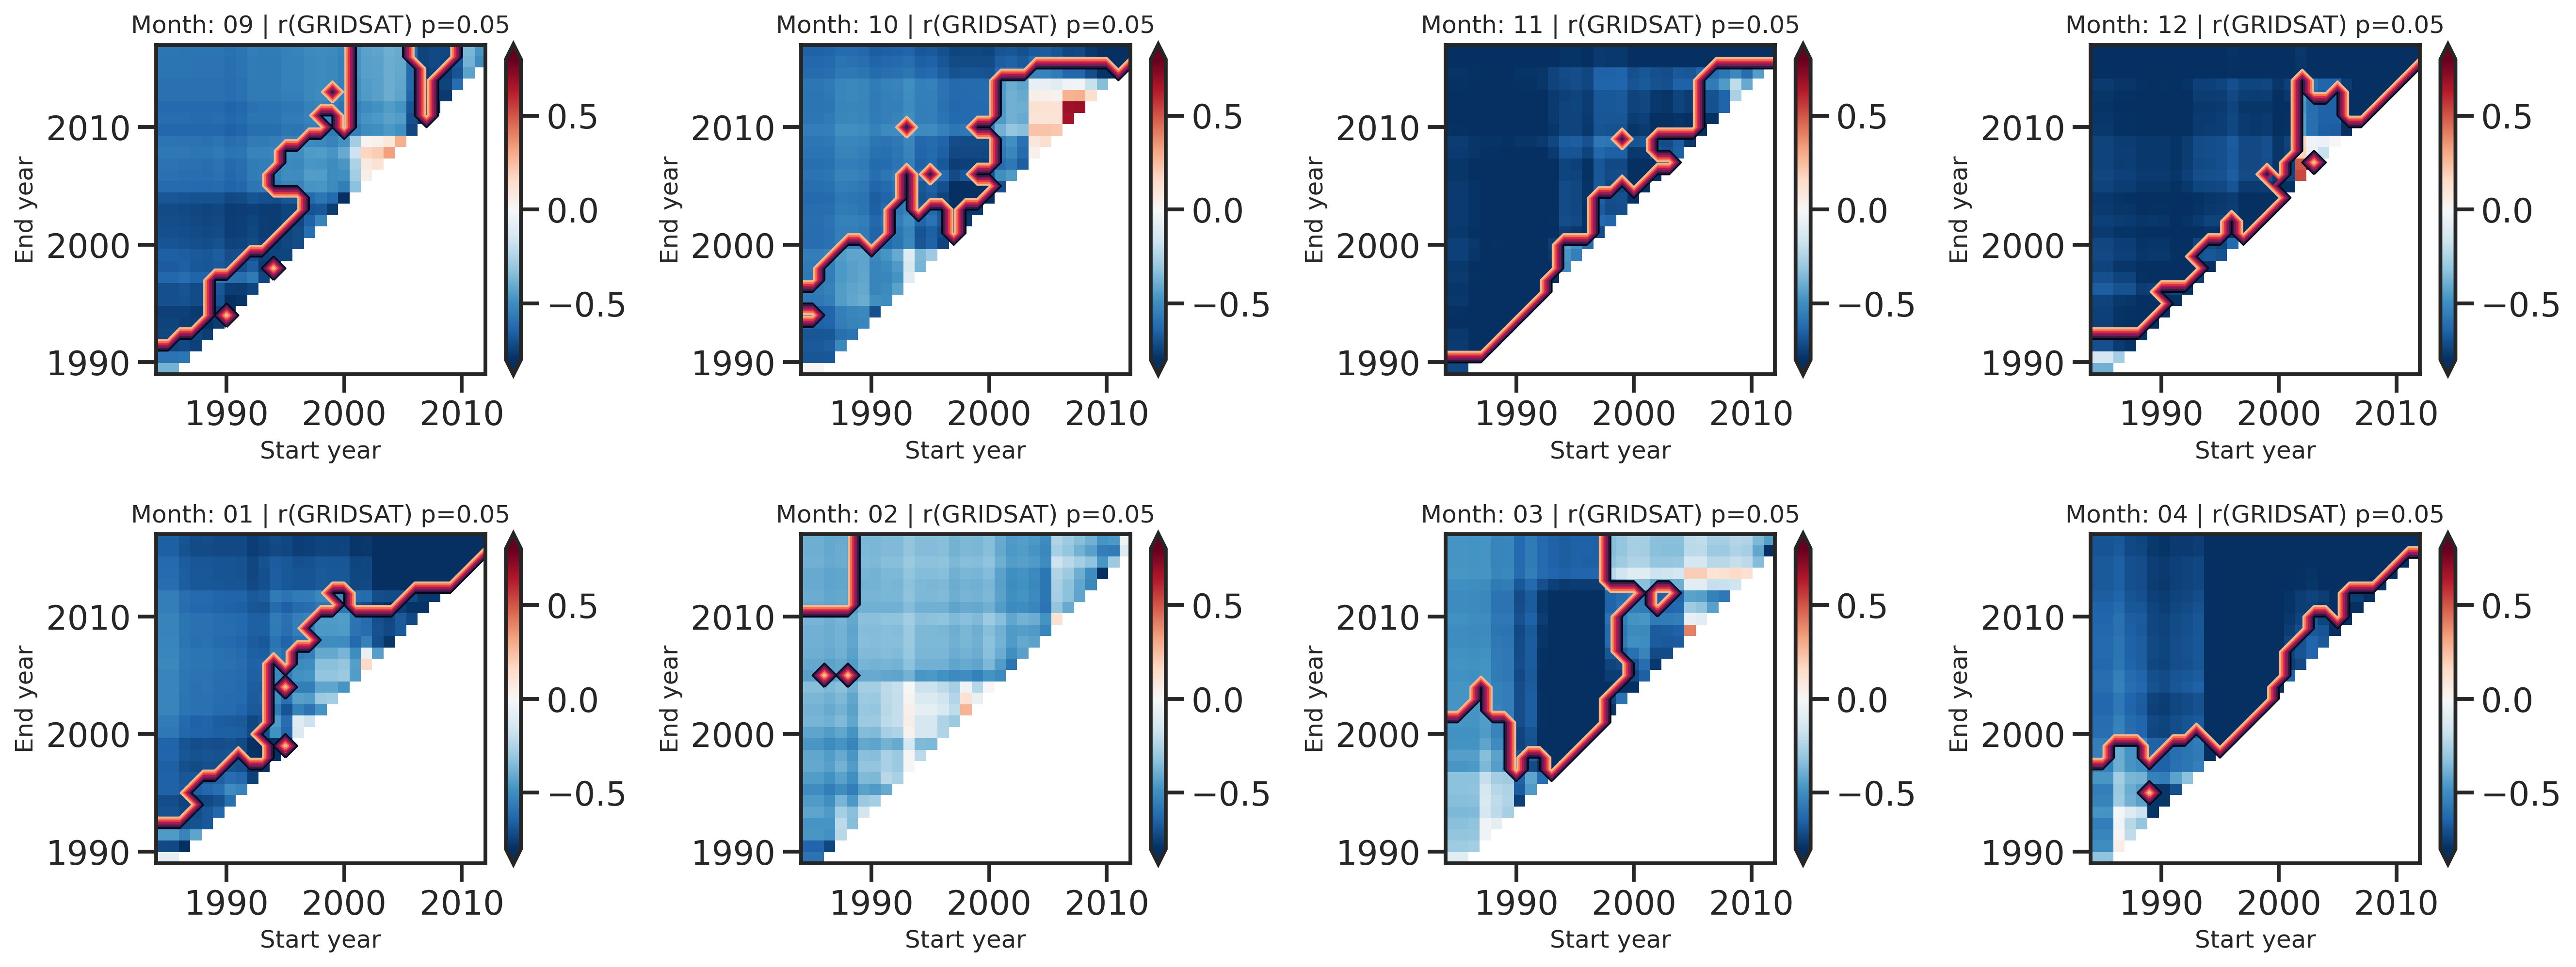

In [35]:
f = plt.figure(figsize=(18,7), dpi=300)
months = [9,10,11,12,1,2,3,4]

for ids, m in enumerate(months): 
    
    trend, sig = monthly(m, era_valley,da3)
    

    ax = f.add_subplot(2,4,ids+1)
        
    im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
    plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=1)
    plt.colorbar(im, extend='both');
    plt.title('Month: '+str(m).zfill(2)+' | r(GRIDSAT) p=0.05', fontsize=12);
    plt.xlabel('Start year', fontsize=12);
    plt.ylabel('End year', fontsize=12);

plt.tight_layout() 
#f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_monthly_GRIDSATvsU200_'+tag+'.jpg')

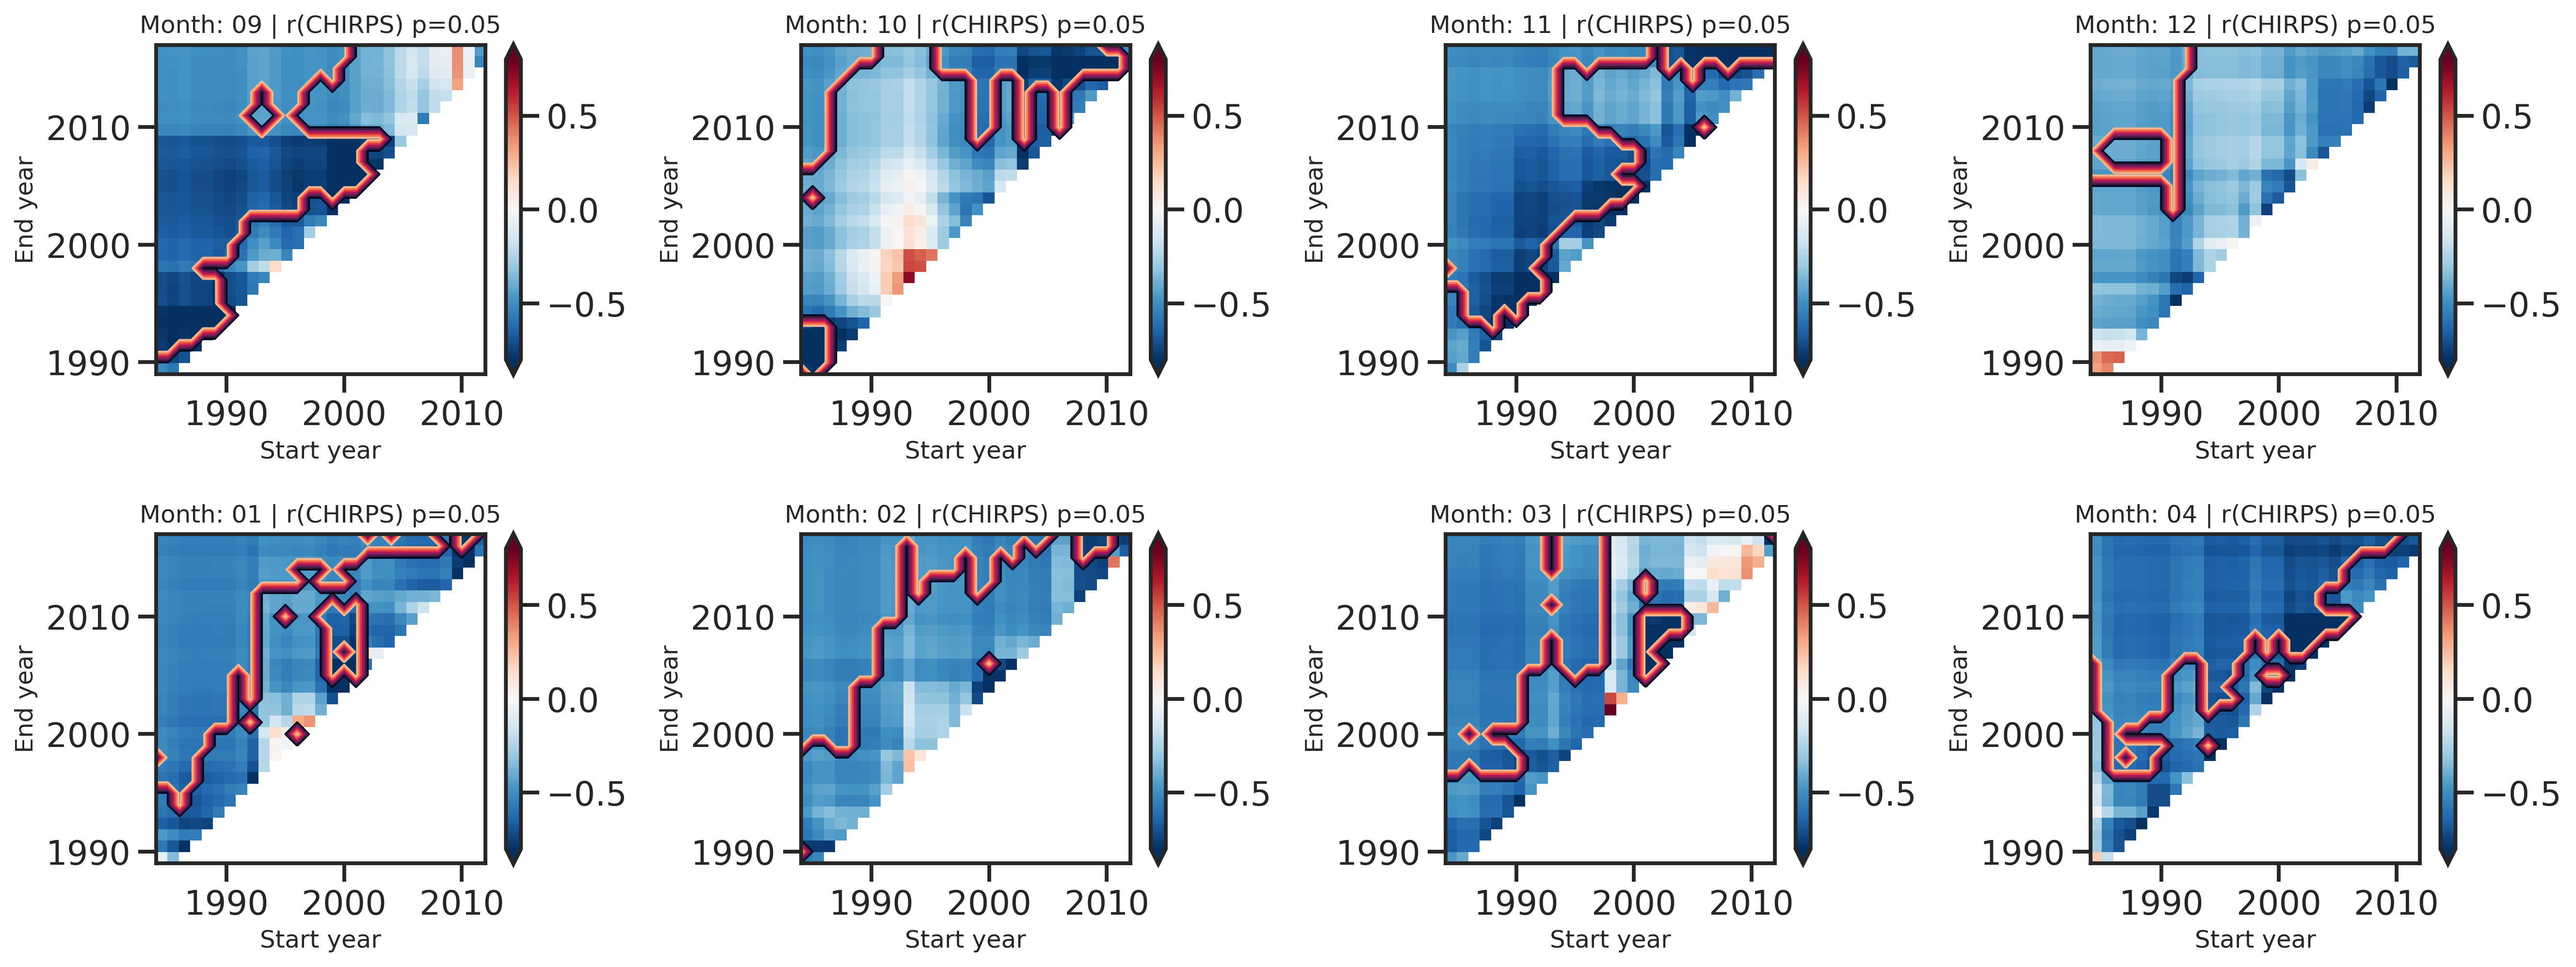

In [166]:
f = plt.figure(figsize=(18,7), dpi=300)
months = [9,10,11,12,1,2,3,4]

for ids, m in enumerate(months): 
    
    trend, sig = monthly(m, era_valley,ca)
    

    ax = f.add_subplot(2,4,ids+1)
        
    im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
    plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=1)
    plt.colorbar(im, extend='both');
    plt.title('Month: '+str(m).zfill(2)+' | r(CHIRPS) p=0.05', fontsize=12);
    plt.xlabel('Start year', fontsize=12);
    plt.ylabel('End year', fontsize=12);
plt.tight_layout() 
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_monthly_CHIRPSvsU200_'+tag+'.jpg')